<a href="https://colab.research.google.com/github/Team-AlmaBetter/Retail-Sales-Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#<b>Import necessary libraries

In [21]:
import pandas as pd, datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

#<b>Import Datasets

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv('/content/drive/MyDrive/Retail Sales- Capstone 2/Data & Resources/Rossmann Stores Data.csv')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df.shape

(1017209, 9)

In [5]:
store = pd.read_csv('/content/drive/MyDrive/Retail Sales- Capstone 2/Data & Resources/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
store.shape

(1115, 10)

#<B>Merge Data

In [24]:
data = df.merge(store, on = ['Store'], how = 'inner')
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [8]:
data.shape

(1017209, 18)

In [9]:
data.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [12]:
print('Distinct number of Stores:', len(data['Store'].unique()))
print('Distinct number of Dates:', len(data['Date'].unique()))
print('Average daily sales of all Stores:', round(data['Sales'].mean(), 2))

Distinct number of Stores: 1115
Distinct number of Dates: 942
Average daily sales of all Stores: 5773.82


In [13]:
data['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

#<B>Create new columns related to Dates


In [25]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format = True)

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Week'] = data['Date'].dt.week
data['Day'] = data['Date'].dt.day

data['Season'] = np.where(data['Month'].isin([3,4,5]), "Spring",
                 np.where(data['Month'].isin([6,7,8]), "Summer",
                 np.where(data['Month'].isin([9,10,11]), "Fall",
                 np.where(data['Month'].isin([12,1,2]), "Winter", "None"))))

In [15]:
data.iloc[:,-6:].head()

,Year,Month,Quarter,Week,Day,Season
0,2015,7,3,31,31,Summer
1,2015,7,3,31,30,Summer
2,2015,7,3,31,29,Summer
3,2015,7,3,31,28,Summer
4,2015,7,3,31,27,Summer


#<b>Exploratory Data Analysis & Visualization

In [16]:
data.describe (include= 'all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Quarter,Week,Day,Season
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1017209,1017209,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,509178,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,2015-06-09 00:00:00,NaN,NaN,NaN,NaN,0,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct",NaN,NaN,NaN,NaN,NaN,Spring
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN,551627,537445,NaN,NaN,NaN,NaN,NaN,NaN,293122,NaN,NaN,NaN,NaN,NaN,307740
first,NaN,NaN,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01,NaN,NaN,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,NaN,2.013832e+03,5.846762e+00,2.294252e+00,2.361551e+01,1.570279e+01,NaN
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01,NaN,NaN,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,NaN,7.773960e-01,3.326097e+00,1.081850e+00,1.443338e+01,8.787638e+00,NaN
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,NaN,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,NaN,2.013000e+03,3.000000e+00,1.000000e+00,1.100000e+01,8.000000e+00,NaN


In [8]:
data.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Year                                  int64
Month                                 int64
Quarter                               int64
Week                                  int64
Day                             

In [9]:
# days on which store closed, with zero sales has to be removed
closed_stores = data[data['Open'] == 0]. index
data.drop (closed_stores, inplace=True)

In [10]:
# checking for missing values
data.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
Year                              0
Month                             0
Quarter                           0
Week                              0
Day                               0
Season                            0
dtype: int64

In [34]:
# adding column of SalesperCustomer
data['SalesperCustomer'] = data['Sales']/data['Customers']
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Quarter,Week,Day,Season,SalesPerCustomer,SalesperCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,31,Summer,9.482883,9.482883
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,30,Summer,9.194139,9.194139
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,29,Summer,9.143403,9.143403
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,28,Summer,8.948214,8.948214
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,27,Summer,9.970588,9.970588


In [11]:
# filling competition distance with mean
data['CompetitionDistance'].fillna(data['CompetitionDistance'].mean(), inplace = True)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


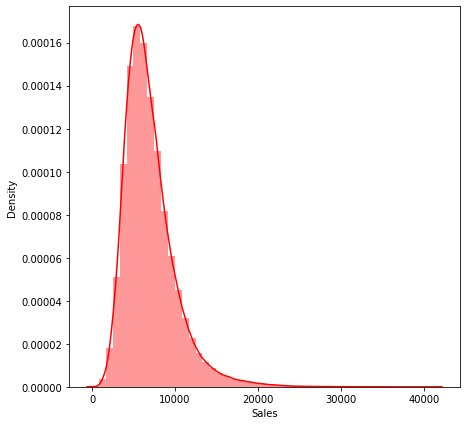

In [13]:
#plotting dependent variable "Sales"
plt.figure(figsize = (7,7))
sns.distplot(data['Sales'], color='r')

Positively skewed, log transformation reqd

Text(0.5, 1.0, 'Average Spending per Customer in each Store Type \n Fig 1.6')

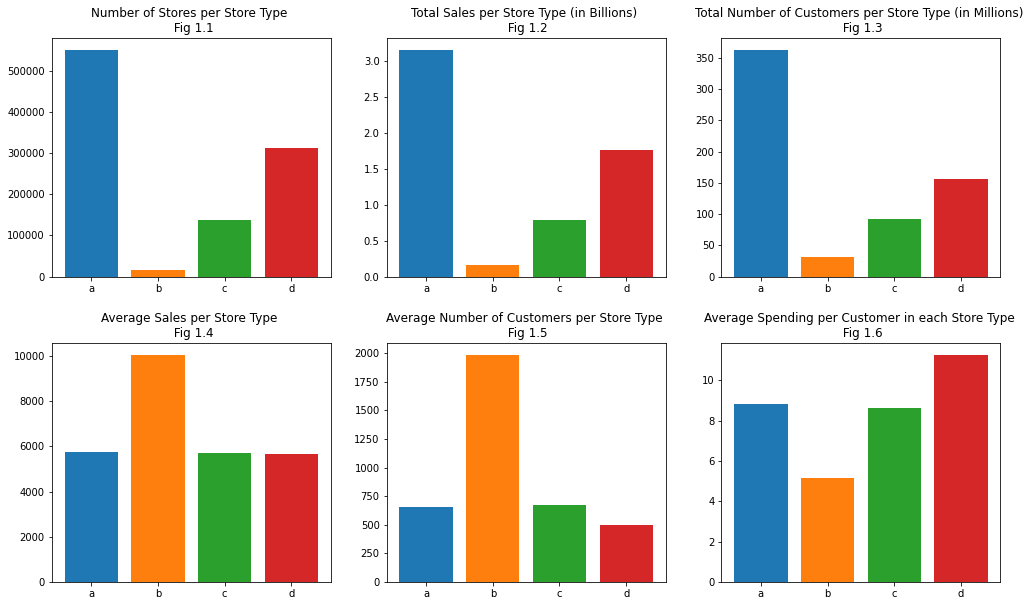

In [35]:
fig, axes = plt.subplots(2, 3,figsize=(17,10) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes[0,0].bar(data.groupby(by="StoreType").count().Store.index,data.groupby(by="StoreType").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("Number of Stores per Store Type \n Fig 1.1")
axes[0,1].bar(data.groupby(by="StoreType").sum().Sales.index,data.groupby(by="StoreType").sum().Sales/1e9,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("Total Sales per Store Type (in Billions) \n Fig 1.2")
axes[0,2].bar(data.groupby(by="StoreType").sum().Customers.index,data.groupby(by="StoreType").sum().Customers/1e6,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,2].set_title("Total Number of Customers per Store Type (in Millions) \n Fig 1.3")
axes[1,0].bar(data.groupby(by="StoreType").sum().Customers.index,data.groupby(by="StoreType").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Average Sales per Store Type \n Fig 1.4")
axes[1,1].bar(data.groupby(by="StoreType").sum().Customers.index,data.groupby(by="StoreType").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("Average Number of Customers per Store Type \n Fig 1.5")
axes[1,2].bar(data.groupby(by="StoreType").sum().Sales.index,data.groupby(by="StoreType").SalesPerCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,2].set_title("Average Spending per Customer in each Store Type \n Fig 1.6")



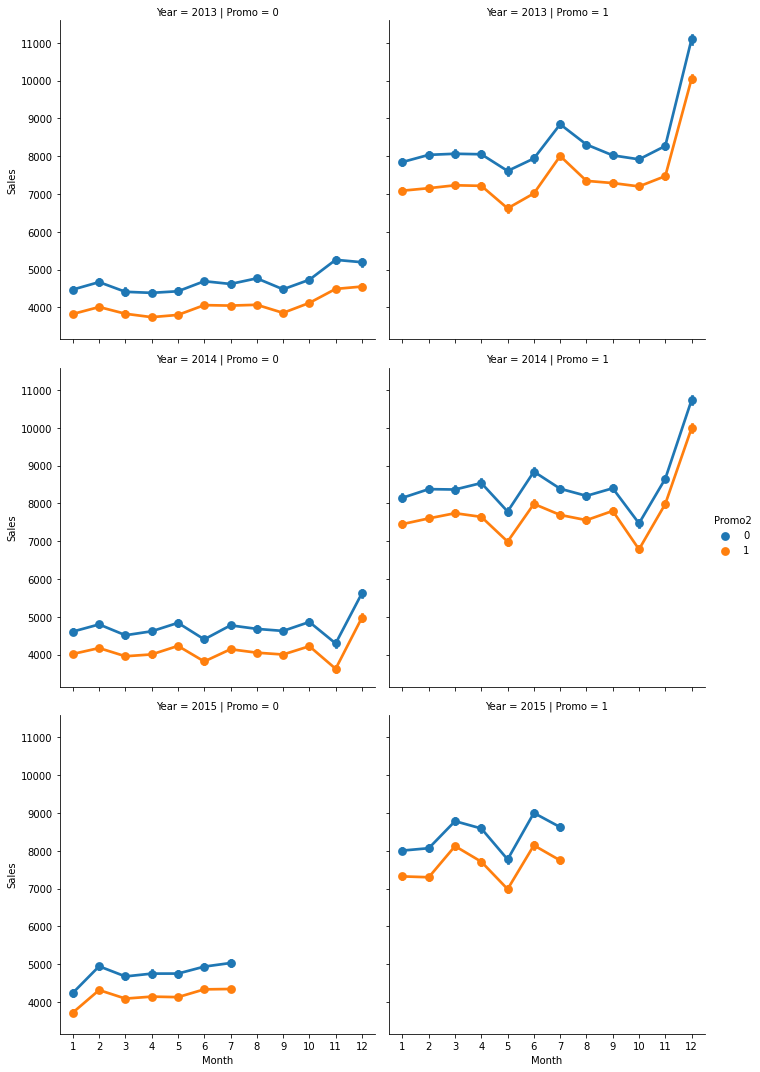

In [26]:
# Sales trend over the months and year
sns.factorplot(data = data, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year")

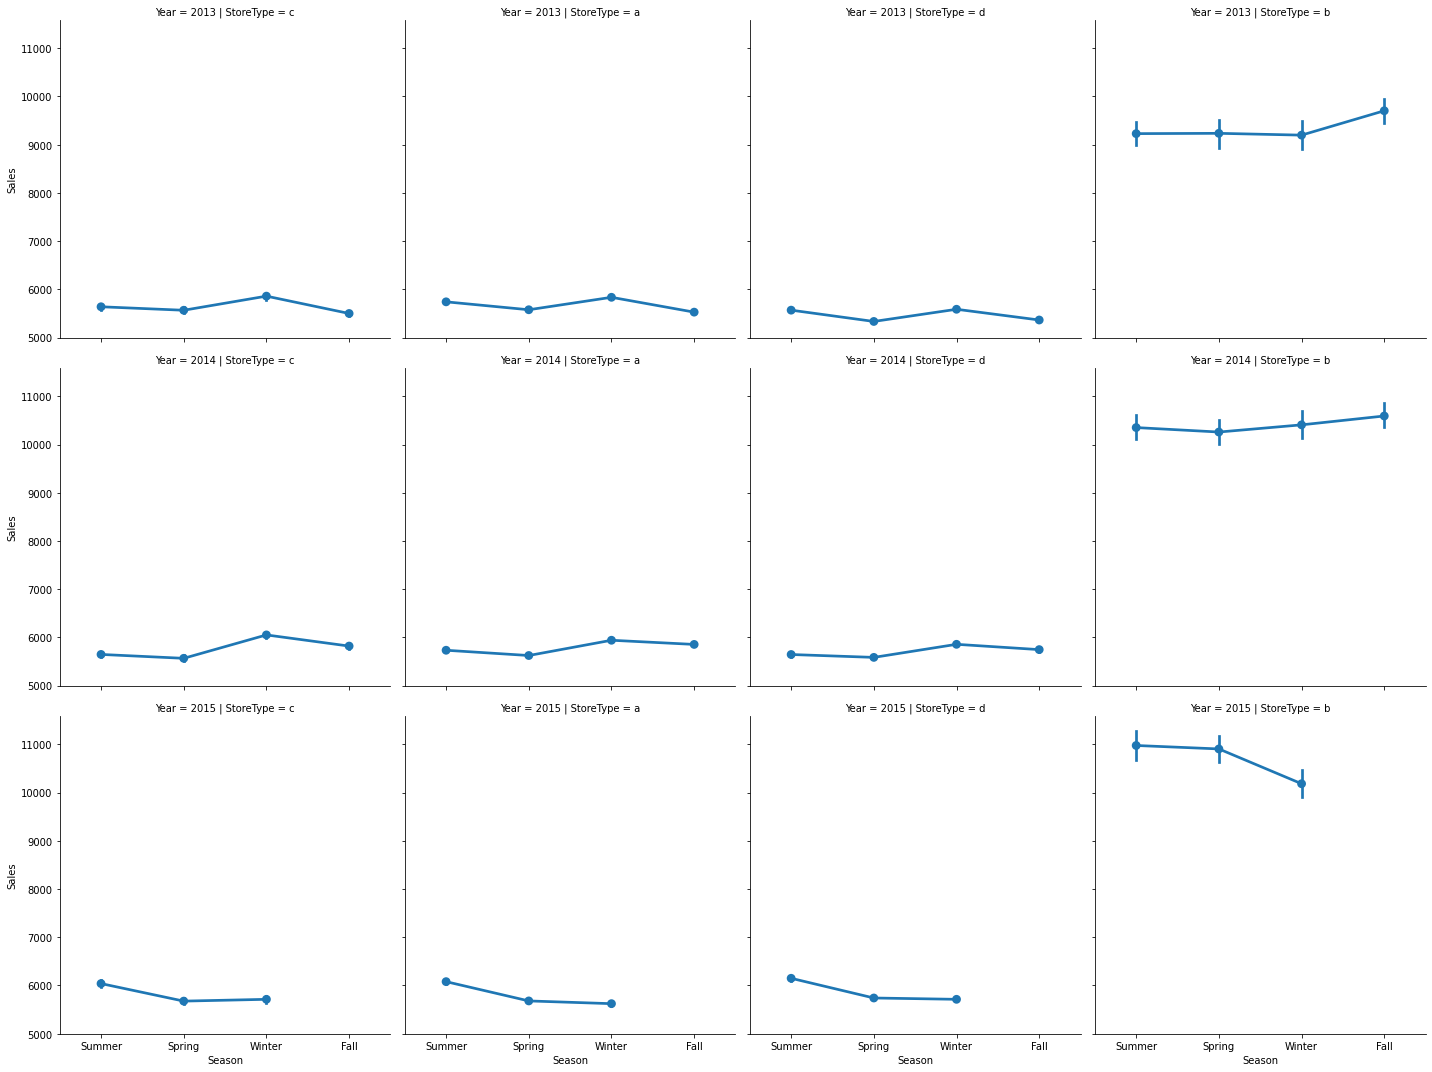

In [28]:
# Sales trend over the seasons and year
sns.factorplot(data = data, x ="Season", y = "Sales", 
               col = 'StoreType',
               row = "Year")